In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import time
from torchvision import datasets
import os
# from patchify import patchify, unpatchify
import numpy as np
import tensorflow as tf
from transformers import ViTImageProcessor, ViTForImageClassification, ViTFeatureExtractor
import torchvision.transforms.functional as F
from PIL import Image
from torch.utils.data import Dataset, random_split
matplotlib.style.use('ggplot')

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor()
                                ])

In [5]:
batch_size = 8
fake_dir = '/content/drive/MyDrive/Datasets/FF++/Sample Dataset/C23/Manipulated/DeepFake'
real_dir = '/content/drive/MyDrive/Datasets/FF++/Sample Dataset/C23/Original/Original'

class CustomImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        self.files = [os.path.join(path, f) for f in os.listdir(path)]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        image = Image.open(file)
        label = 0 if "Original" in file else 1
        if self.transform:
            image = self.transform(image)
        return image, label

custom_fake_dataset = CustomImageDataset(fake_dir, transform=transform)

total_samples = len(custom_fake_dataset)
train_size = 2938 #int(0.7 * total_samples)
val_size = 200 #int(0.2 * total_samples)
test_size = 100 #total_samples - train_size - val_size
rem_size =  total_samples - train_size - val_size - test_size

fake_train_subset, fake_val_subset, fake_test_subset, _ = random_split(
    custom_fake_dataset, [train_size, val_size, test_size, rem_size]
)

custom_real_dataset = CustomImageDataset(real_dir, transform=transform)

total_samples = len(custom_real_dataset)
train_size = 2938 # int(0.7 * total_samples)
val_size = 200 # int(0.2 * total_samples)
test_size = 100 # total_samples - train_size - val_size
rem_size =  total_samples - train_size - val_size - test_size

real_train_subset, real_val_subset, real_test_subset, _ = random_split(
    custom_real_dataset, [train_size, val_size, test_size, rem_size]
)

train_dataset = torch.utils.data.ConcatDataset([fake_train_subset, real_train_subset])
val_dataset = torch.utils.data.ConcatDataset([fake_val_subset, real_val_subset])
test_dataset = torch.utils.data.ConcatDataset([fake_test_subset, real_test_subset])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             shuffle=False)

In [6]:
print("Train Loader Length", len(train_dataset))
print("Validation Loader Length", len(val_dataset))
print("Test Loader Length", len(test_dataset))

Train Loader Length 5876
Validation Loader Length 400
Test Loader Length 200


Feature batch shape: torch.Size([8, 3, 224, 224])
Labels batch shape: torch.Size([8])


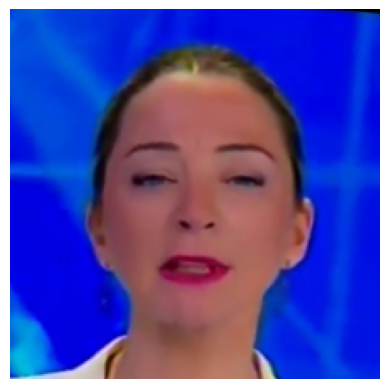

Label: 0


In [8]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.show()
print(f"Label: {label}")

In [ ]:
class Xception(nn.Module):
  def __init__(self):
        super(Xception, self).__init__()
        self.xception_model = tf.keras.applications.xception.Xception(
            include_top=False,
            weights='imagenet',
            input_shape = (224, 224, 3)
        )
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()

  def forward(self, x):
        x = x.permute(0, 2,3, 1)
        x = tf.keras.applications.xception.preprocess_input(x)
        output = self.xception_model(x.numpy())
        output = self.global_avg_pool(output.numpy())
        return output.numpy()

In [ ]:
class PatchModule(nn.Module):
  def __init__(self):
    super(PatchModule, self).__init__()
    self.conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding="same")

  def forward(self, x):
    conv_image = self.conv(x)
    output_image = x * conv_image
    return output_image

In [ ]:
class VIT_Encoder(nn.Module):
  def __init__(self):
    super(VIT_Encoder, self).__init__()
    self.processor = ViTImageProcessor().from_pretrained('google/vit-base-patch16-224')
    self.vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

  def forward(self, x):
    x = x - torch.min(x)
    x = x/torch.max(x)
    inputs = self.processor(images=x, return_tensors="pt")
    outputs = self.vit_model(**inputs)
    logits = outputs.logits
    return logits

In [ ]:
class Classification_Module(nn.Module):
  def __init__(self):
    super(Classification_Module, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(3048, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 2),
    )

  def forward(self, input):
    return self.model(input)

In [ ]:
class ViXNet(nn.Module):
    def __init__(self):
      super(ViXNet, self).__init__()
      self.patch_module = PatchModule()
      self.vit_encoder = VIT_Encoder()
      self.xception = Xception()
      self.classification = Classification_Module()

    def forward(self, x):
      patch_module_output = self.patch_module(x)
      vit_output = self.vit_encoder(patch_module_output)
      xception_output = self.xception(x)
      output = torch.cat((
          vit_output,
          torch.tensor(xception_output)
          ), dim=1)

      output = self.classification(output)
      return output

In [ ]:
model = ViXNet().to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

83683744/83683744 [==============================] - 1s 0us/step
ViXNet(
  (patch_module): PatchModule(
    (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (vit_encoder): VIT_Encoder(
    (vit_model): ViTForImageClassification(
      (vit): ViTModel(
        (embeddings): ViTEmbeddings(
          (patch_embeddings): ViTPatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): ViTEncoder(
          (layer): ModuleList(
            (0-11): 12 x ViTLayer(
              (attention): ViTAttention(
                (attention): ViTSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def train(model, trainloader, optimizer, loss_fn):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = loss_fn(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()

    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
# validation Of Model
def validate(model, testloader, loss_fn):
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Author ran for 50 Epochs
epochs = 20
since = time.time()
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, trainloader,
                                              optimizer, loss_fn)
    valid_epoch_loss, valid_epoch_acc = validate(model, validloader,
                                                 loss_fn)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

[INFO]: Epoch 1 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.732, training acc: 50.000
Validation loss: 0.693, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.711, training acc: 50.000
Validation loss: 0.693, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.698, training acc: 50.000
Validation loss: 0.693, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.697, training acc: 16.667
Validation loss: 0.693, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.689, training acc: 50.000
Validation loss: 0.694, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.684, training acc: 50.000
Validation loss: 0.694, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.680, training acc: 50.000
Validation loss: 0.696, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.676, training acc: 50.000
Validation loss: 0.698, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.672, training acc: 50.000
Validation loss: 0.700, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.669, training acc: 50.000
Validation loss: 0.703, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.666, training acc: 50.000
Validation loss: 0.707, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.664, training acc: 50.000
Validation loss: 0.710, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.663, training acc: 50.000
Validation loss: 0.714, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.662, training acc: 50.000
Validation loss: 0.718, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.662, training acc: 50.000
Validation loss: 0.722, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.662, training acc: 50.000
Validation loss: 0.724, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.663, training acc: 50.000
Validation loss: 0.727, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.663, training acc: 50.000
Validation loss: 0.728, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.663, training acc: 50.000
Validation loss: 0.729, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.664, training acc: 50.000
Validation loss: 0.730, validation acc: 50.000
--------------------------------------------------
Training complete in 6m 29s


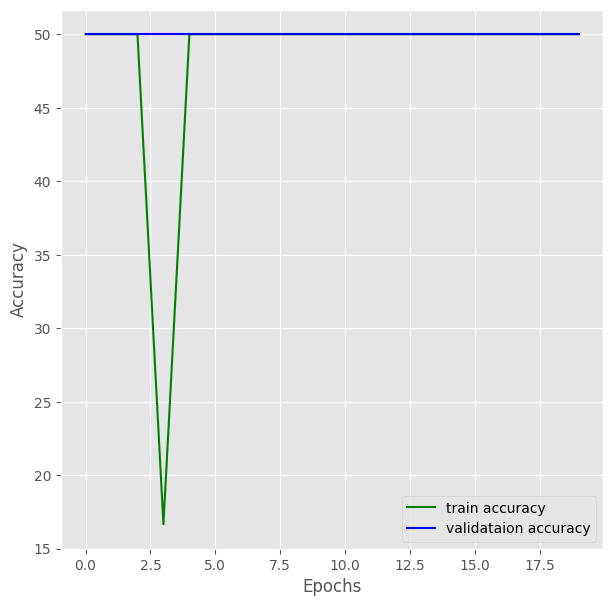

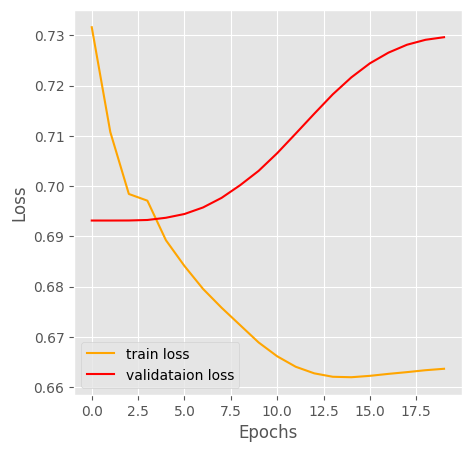

MODEL SAVED...


In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(
    train_acc, color='green', linestyle='-',
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-',
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/accuracytl.png')
plt.show()
# loss plots
plt.figure(figsize=(5, 5))
plt.plot(
    train_loss, color='orange', linestyle='-',
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-',
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/losstl.png')
plt.show()
# save the final model
save_path = 'model_res.pth'
torch.save(model.state_dict(), save_path)
print('MODEL SAVED...')